# Import all libraries needed for this project

In [43]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import difflib as dl
import requests 
import time
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Scraping all data from the IGDB API.

In [44]:
# Your Client ID and Access Token (replace with actual values)
client_id = '2s6fe3ts3br2aikeue6v2mvpspjkf3'
access_token = 'yn7ihok1yufl8el6tgv4zm14g32rnk'

# IGDB API endpoint
url = 'https://api.igdb.com/v4/games'

# Headers for the request
headers = {
    'Client-ID': client_id,
    'Authorization': f'Bearer {access_token}',
}

# Fields you want to fetch for each game
fields = '''
fields id, name, rating, rating_count, age_ratings, aggregated_rating, aggregated_rating_count, 
alternative_names, artworks, bundles, category, checksum, collection, collections, cover, created_at, 
dlcs, expanded_games, expansions, external_games, first_release_date, follows, forks, franchise, franchises, 
game_engines, game_localizations, game_modes, genres, hypes, involved_companies, keywords, language_supports, 
multiplayer_modes, parent_game, platforms, player_perspectives, ports, release_dates, remakes, remasters, screenshots, 
slug, standalone_expansions, status, summary, tags, themes, total_rating, total_rating_count, updated_at, url, version_parent, version_title, videos, websites;
where rating != null & rating_count != null & total_rating != null & total_rating_count != null;
'''

# Track the time to check duration
start_time = time.time()

# Make the request to the API
try:
    response = requests.post(url, headers=headers, data=fields)
    response.raise_for_status()  # Check for HTTP errors
    
    # Log the time taken for the request
    print(f"Request took {time.time() - start_time:.2f} seconds")
    
    # Check the response content
    if response.status_code == 200:
        print("Request successful.")
        data = response.json()  # Parse the JSON response
        print(f"Received {len(data)} games.")
    else:
        print(f"Request failed with status code: {response.status_code}")
        print(response.text)

except requests.exceptions.HTTPError as http_err:
    print(f"HTTP error occurred: {http_err}")
except Exception as err:
    print(f"An error occurred: {err}")

Request took 0.35 seconds
Request successful.
Received 10 games.


In [45]:
# Function to call the IGDB API and fetch data for a specific endpoint with pagination
def fetch_data(endpoint, limit=500):
    url = f'https://api.igdb.com/v4/{endpoint}'
    offset = 0
    all_data = {}
    
    while True:
        # Define the request data with pagination
        data = f'fields id, name; limit {limit}; offset {offset};'
        
        try:
            response = requests.post(url, headers=headers, data=data)
            response.raise_for_status()  # Check for HTTP errors
            
            items = response.json()
            if not items:
                break  # No more data, exit loop

            # Update dictionary with id-name mapping
            all_data.update({item['id']: item['name'] for item in items if 'id' in item and 'name' in item})
            
            # Increase the offset for the next batch
            offset += limit
        except requests.exceptions.HTTPError as err:
            print(f"HTTP error occurred: {err}")
            break
        except Exception as err:
            print(f"An error occurred: {err}")
            break
        
        # Pause to avoid hitting rate limits
        time.sleep(1)
    
    return all_data

# Special function to handle multiplayer_modes and their specific fields
def fetch_multiplayer_modes():
    url = 'https://api.igdb.com/v4/multiplayer_modes'
    offset = 0
    limit = 500
    multiplayer_data = {}

    while True:
        data = f'fields id, game, platform, campaigncoop, onlinecoop, offlinecoop, lancoop, dropin, splitscreen, splitscreenonline, offlinecoopmax, onlinemax; limit {limit}; offset {offset};'
        
        try:
            response = requests.post(url, headers=headers, data=data)
            response.raise_for_status()
            
            items = response.json()
            if not items:
                break

            # For each item, create a descriptive string based on the multiplayer mode flags
            for item in items:
                mode_description = []

                if item.get('campaigncoop'):
                    mode_description.append('Campaign Co-op')
                if item.get('onlinecoop'):
                    mode_description.append('Online Co-op')
                if item.get('offlinecoop'):
                    mode_description.append('Offline Co-op')
                if item.get('lancoop'):
                    mode_description.append('LAN Co-op')
                if item.get('dropin'):
                    mode_description.append('Drop-in Multiplayer')
                if item.get('splitscreen'):
                    mode_description.append('Split Screen Multiplayer')
                if item.get('splitscreenonline'):
                    mode_description.append('Split Screen Online Multiplayer')
                if item.get('onlinemax'):
                    mode_description.append(f"Online Max Players: {item['onlinemax']}")
                if item.get('offlinecoopmax'):
                    mode_description.append(f"Offline Co-op Max Players: {item['offlinecoopmax']}")

                # Combine descriptions and map it to the game id
                multiplayer_data[item['id']] = ', '.join(mode_description)
            
            # Increase the offset for the next batch
            offset += limit
        except requests.exceptions.HTTPError as err:
            print(f"HTTP error occurred: {err}")
            break
        except Exception as err:
            print(f"An error occurred: {err}")
            break

        # Pause to avoid hitting rate limits
        time.sleep(1)

    return multiplayer_data

# Fetch relevant data for each field and create a mapping dictionary
franchise_dict = fetch_data('franchises')
game_engine_dict = fetch_data('game_engines')
game_localizations_dict = fetch_data('game_localizations')
game_modes_dict = fetch_data('game_modes')
companies_dict = fetch_data('companies')
language_support_dict = fetch_data('languages')
multiplayer_modes_dict = fetch_multiplayer_modes()  # Using the special function for multiplayer_modes
platform_dict = fetch_data('platforms')
player_perspectives_dict = fetch_data('player_perspectives')
theme_dict = fetch_data('themes')
generes_dict = fetch_data('genres')

# Helper function to handle lists of IDs and convert them to names
def format_name_id(data_list, mapping_dict=None):
    if isinstance(data_list, list):  # If it's a list
        formatted_items = []
        for item in data_list:
            if isinstance(item, int):  # Handle case where it's just an ID
                formatted_items.append(f"{mapping_dict.get(item, 'Unknown')} ({item})" if mapping_dict else str(item))
        return '|'.join(formatted_items)
    elif isinstance(data_list, int):  # If it's just a single ID
        return f"{mapping_dict.get(data_list, 'Unknown')} ({data_list})" if mapping_dict else str(data_list)
    return 'N/A'

# Function to fetch all games with pagination and store each game's details in a list
def fetch_all_games(limit=500, fields=''):
    all_games = []
    offset = 0
    game_count = 0  # To keep track of the total number of games

    while True:
        # Build the body with limit and offset to paginate through results
        body = f'{fields} limit {limit}; offset {offset};'
        
        # Make the API request
        response = requests.post('https://api.igdb.com/v4/games', headers=headers, data=body)
        
        # Check if the request was successful
        if response.status_code == 200:
            games = response.json()
            
            # Break the loop if no more games are returned
            if not games:
                print("No more games to fetch.")
                break
            
            # Process each game's details and store them in a list of formatted strings
            for game in games:
                game_info = {
                    'ID': str(game.get('id', 'N/A')),
                    'Name': str(game.get('name', 'N/A')),
                    'Rating': str(game.get('rating', 'N/A')),
                    'Rating Count': str(game.get('rating_count', 'N/A')),
                    'Age Ratings': format_name_id(game.get('age_ratings', [])),
                    'Aggregated Rating': str(game.get('aggregated_rating', 'N/A')),
                    'Aggregated Rating Count': str(game.get('aggregated_rating_count', 'N/A')),
                    'Alternative Names': format_name_id(game.get('alternative_names', [])),
                    'Artworks': format_name_id(game.get('artworks', [])),
                    'Bundles': format_name_id(game.get('bundles', [])),
                    'Category': str(game.get('category', 'N/A')),
                    'Checksum': str(game.get('checksum', 'N/A')),
                    'Collection': str(game.get('collection', 'N/A')),
                    'Collections': format_name_id(game.get('collections', [])),
                    'Cover': str(game.get('cover', 'N/A')),
                    'Created At': str(game.get('created_at', 'N/A')),
                    'DLCs': format_name_id(game.get('dlcs', [])),
                    'Expanded Games': format_name_id(game.get('expanded_games', [])),
                    'Expansions': format_name_id(game.get('expansions', [])),
                    'External Games': format_name_id(game.get('external_games', [])),
                    'First Release Date': str(game.get('first_release_date', 'N/A')),
                    'Follows': str(game.get('follows', 'N/A')),
                    'Forks': format_name_id(game.get('forks', [])),
                    'Franchise': format_name_id(game.get('franchise', [])),
                    'Franchise Name': format_name_id(game.get('franchise', []), mapping_dict=franchise_dict),
                    'Game Engines': format_name_id(game.get('game_engines', [])),
                    'Game Engine Name': format_name_id(game.get('game_engines', []), mapping_dict=game_engine_dict),
                    'Game Localizations': format_name_id(game.get('game_localizations', [])),
                    'Game Modes': format_name_id(game.get('game_modes', []), mapping_dict=game_modes_dict),
                    'Genres': format_name_id(game.get('genres', []), mapping_dict=generes_dict),
                    'Hypes': str(game.get('hypes', 'N/A')),
                    'Involved Companies': format_name_id(game.get('involved_companies', [])),
                    'Company Names': format_name_id(game.get('involved_companies', []), mapping_dict=companies_dict),
                    'Keywords': format_name_id(game.get('keywords', [])),
                    'Language Supports': format_name_id(game.get('language_supports', []), mapping_dict=language_support_dict),
                    'Multiplayer Modes': format_name_id(game.get('multiplayer_modes', []), mapping_dict=multiplayer_modes_dict),
                    'Platforms': format_name_id(game.get('platforms', []), mapping_dict=platform_dict),
                    'Player Perspectives': format_name_id(game.get('player_perspectives', []), mapping_dict=player_perspectives_dict),
                    'Ports': format_name_id(game.get('ports', [])),
                    'Release Dates': format_name_id(game.get('release_dates', [])),
                    'Remakes': format_name_id(game.get('remakes', [])),
                    'Remasters': format_name_id(game.get('remasters', [])),
                    'Screenshots': format_name_id(game.get('screenshots', [])),
                    'Slug': str(game.get('slug', 'N/A')),
                    'Standalone Expansions': format_name_id(game.get('standalone_expansions', [])),
                    'Status': str(game.get('status', 'N/A')),
                    'Storyline': str(game.get('storyline', 'N/A')),
                    'Tags': format_name_id(game.get('tags', [])),
                    'Themes': format_name_id(game.get('themes', []), mapping_dict=theme_dict),
                    'Theme Name': format_name_id(game.get('themes', []), mapping_dict=theme_dict),
                    'Total Rating': str(game.get('total_rating', 'N/A')),
                    'Total Rating Count': str(game.get('total_rating_count', 'N/A')),
                    'Updated At': str(game.get('updated_at', 'N/A')),
                    'URL': str(game.get('url', 'N/A')),
                    'Version Parent': format_name_id(game.get('version_parent', [])),
                    'Version Title': str(game.get('version_title', 'N/A')),
                    'Videos': format_name_id(game.get('videos', [])),
                    'Websites': format_name_id(game.get('websites', []))
                }
                all_games.append(game_info)
            
            # Update the total game count
            game_count += len(games)
            
            # Increment the offset for the next batch of games
            offset += limit
            
            # Pause to respect rate limits
            time.sleep(0.3)  # Wait 300ms between requests (4 requests per second limit)
        else:
            print(f"Failed to fetch data: {response.status_code}")
            print(response.text)
            break

    print(f"Total games fetched: {game_count}")
    return all_games

# Fetch all the games
games_data = fetch_all_games(limit=500, fields=fields)

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(games_data)

# Save the DataFrame to a CSV file
df.to_csv('igdb_games_data.csv', index=False)

print(f"Game data saved to igdb_games_data.csv with {len(df)} games.")

No more games to fetch.
Total games fetched: 30887
Game data saved to igdb_games_data.csv with 30887 games.


## Let's visualize the table and see how it turned out so far

In [46]:
# Load the saved data
games_data = pd.read_csv('igdb_games_data.csv')
games_data.head()

,ID,Name,Rating,Rating Count,Age Ratings,Aggregated Rating,Aggregated Rating Count,Alternative Names,Artworks,Bundles,...,Themes,Theme Name,Total Rating,Total Rating Count,Updated At,URL,Version Parent,Version Title,Videos,Websites
0,215217,Tiny Rogues,91.641903,5,162917,NaN,NaN,NaN,86350,NaN,...,Action (1)|Fantasy (17),Action (1)|Fantasy (17),91.641903,5,1725962367,https://www.igdb.com/games/tiny-rogues,NaN,NaN,74227|104239,307462|307463|501746|605460
1,134161,Sherlock Holmes: Chapter One,76.998097,23,52194|77618|84502|101712|114624|138537,76.888889,9.0,35255|96953,11658,201012|201013|209687|254703|254705,...,Action (1)|Thriller (20)|Open world (38)|Myste...,Action (1)|Thriller (20)|Open world (38)|Myste...,76.943493,32,1726665334,https://www.igdb.com/games/sherlock-holmes-cha...,NaN,NaN,36359|37179|37791|40261|50700|54781|54782,141632|141633|141634|186177|205432|205433|2214...
2,82461,10tons Adventure Puzzles Bundle,60.000000,0,84506,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,60.000000,0,1670990469,https://www.igdb.com/games/10tons-adventure-pu...,NaN,NaN,NaN,440080
3,236547,Thronefall,77.856060,14,NaN,NaN,NaN,NaN,NaN,NaN,...,Action (1)|Fantasy (17)|Survival (21),Action (1)|Fantasy (17)|Survival (21),77.856060,14,1725962530,https://www.igdb.com/games/thronefall,NaN,NaN,97151|118938,528578|556705|570629
4,118128,Little Dungeon Stories,50.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,50.000000,0,1713262585,https://www.igdb.com/games/little-dungeon-stories,NaN,NaN,NaN,109257|391447


## Let's clean up duplicate columns

In [47]:
# Function to remove duplicates and keep only one column
def clean_duplicate_columns(df, id_column, name_column):
    """
    Remove one of the columns (ID or Name) to avoid duplication.
    If both columns exist, keep only the Name column.
    """
    # Check if both columns exist
    if id_column in df.columns and name_column in df.columns:
        # Drop the ID column, keeping only the Name column
        df.drop(columns=[id_column], inplace=True)

# List of column pairs to clean (ID, Name)
columns_to_clean = [
    ('Themes', 'Theme Name'),
    ('Platforms', 'Platform Name'),
    ('Franchise', 'Franchise Name'),
    ('Game Engines', 'Game Engine Name'),
    ('Involved Companies', 'Company Names'),
    ('Genres', 'Genre Name'),
    # Add other ID-Name column pairs here
]

# Apply the function to clean the duplicate columns for all relevant pairs
for id_col, name_col in columns_to_clean:
    clean_duplicate_columns(df, id_col, name_col)

# Save the cleaned DataFrame to a CSV file
df.to_csv('igdb_games_data.csv', index=False)

print("Cleaned file saved successfully.")

Cleaned file saved successfully.


## Let's visualize the table again

In [48]:
# Load the so far cleaned data
games_data = pd.read_csv('igdb_games_data.csv')
games_data.head()

,ID,Name,Rating,Rating Count,Age Ratings,Aggregated Rating,Aggregated Rating Count,Alternative Names,Artworks,Bundles,...,Tags,Theme Name,Total Rating,Total Rating Count,Updated At,URL,Version Parent,Version Title,Videos,Websites
0,215217,Tiny Rogues,91.641903,5,162917,NaN,NaN,NaN,86350,NaN,...,1|17|268435461|268435468|268435487|268435488|2...,Action (1)|Fantasy (17),91.641903,5,1725962367,https://www.igdb.com/games/tiny-rogues,NaN,NaN,74227|104239,307462|307463|501746|605460
1,134161,Sherlock Holmes: Chapter One,76.998097,23,52194|77618|84502|101712|114624|138537,76.888889,9.0,35255|96953,11658,201012|201013|209687|254703|254705,...,1|20|38|43|268435487|268435488|536870984|53687...,Action (1)|Thriller (20)|Open world (38)|Myste...,76.943493,32,1726665334,https://www.igdb.com/games/sherlock-holmes-cha...,NaN,NaN,36359|37179|37791|40261|50700|54781|54782,141632|141633|141634|186177|205432|205433|2214...
2,82461,10tons Adventure Puzzles Bundle,60.000000,0,84506,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,60.000000,0,1670990469,https://www.igdb.com/games/10tons-adventure-pu...,NaN,NaN,NaN,440080
3,236547,Thronefall,77.856060,14,NaN,NaN,NaN,NaN,NaN,NaN,...,1|17|21|268435471|268435480|268435488,Action (1)|Fantasy (17)|Survival (21),77.856060,14,1725962530,https://www.igdb.com/games/thronefall,NaN,NaN,97151|118938,528578|556705|570629
4,118128,Little Dungeon Stories,50.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,...,268435468|268435471|268435487|268435488,NaN,50.000000,0,1713262585,https://www.igdb.com/games/little-dungeon-stories,NaN,NaN,NaN,109257|391447


# Visualize and Pre processing of game data CSV file 

In [49]:
# check rows and columns
games_data.shape

(30887, 54)

## We have 55 metrics, but not all of them will be useful. It should also be noted that the intent is to make a content and popularity based system.
### The few metrics that I am certain we will need are: 	
####    •   Genres: Users often prefer specific genres (e.g., action, fantasy). This is a key metric.
####	•	Platforms: Users may prefer games on specific platforms (e.g., PC, PlayStation).
####	•	Game Modes: Single-player or multiplayer preferences are important for users.
####	•	Themes: Similar to genres, but with a different layer of abstraction.
####	•	Involved Companies: Some users prefer games from specific developers or publishers.
####	•	Player Perspectives: The gameplay perspective (e.g., first-person, third-person) can impact preferences.
####	•	Ratings and Rating Count: Popular and highly-rated games are more likely to be recommended.

In [50]:
# Load CSV file
df = pd.read_csv('igdb_games_data.csv')

# Check the data types of the columns
print(df.dtypes)

ID                           int64
Name                        object
Rating                     float64
Rating Count                 int64
Age Ratings                 object
Aggregated Rating          float64
Aggregated Rating Count    float64
Alternative Names           object
Artworks                    object
Bundles                     object
Category                     int64
Checksum                    object
Collection                 float64
Collections                 object
Cover                      float64
Created At                   int64
DLCs                        object
Expanded Games              object
Expansions                  object
External Games              object
First Release Date         float64
Follows                    float64
Forks                       object
Franchise Name              object
Game Engine Name            object
Game Localizations          object
Game Modes                  object
Genres                      object
Hypes               

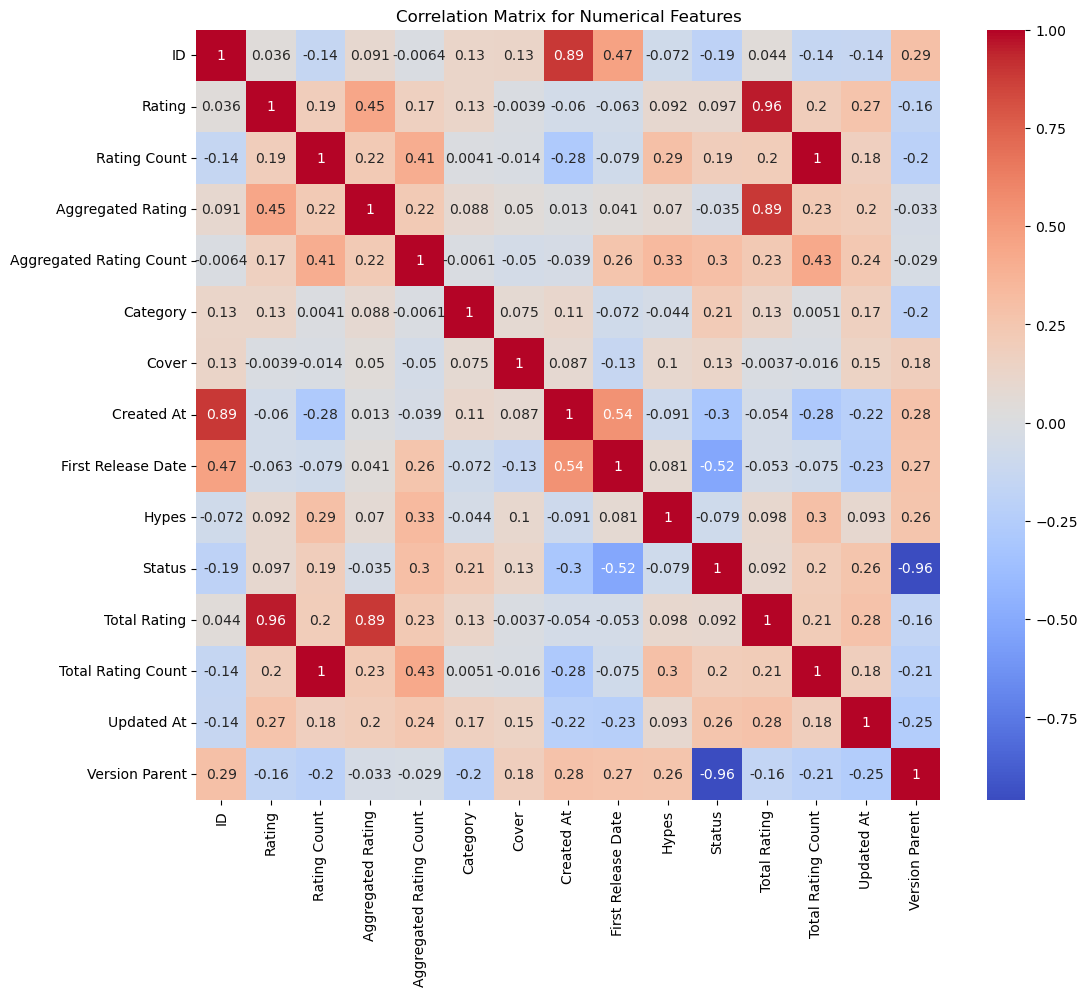

In [51]:
# Select only the numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=[float, int])

# Drop columns that have no variance (i.e., all values are NaN or constant)
numeric_df = numeric_df.dropna(axis=1, how='all').loc[:, (numeric_df != numeric_df.iloc[0]).any()]

# Check if there are any numeric columns left to compute the correlation
if numeric_df.shape[1] > 0:
    # Calculate the correlation matrix
    correlation_matrix = numeric_df.corr()

    # Plot the heatmap for correlation
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix for Numerical Features')
    plt.show()
else:
    print("No numeric columns with variance left to compute the correlation matrix.")

## Observations of the correlation matrix
###	1.	Rating and Total Rating have a very high correlation (0.96), indicating that they are closely related and might represent similar underlying information.
###	2.	Hypes and Collection show a significant negative correlation (-0.75), meaning that games with higher “hypes” tend to belong to collections less frequently.
###	3.	Total Rating Count and Rating Count are highly correlated (1.0), suggesting that they essentially capture the same metric and might be redundant for model training.

In [52]:
#Let's check for missing values in the dataset

numerical_df = df.select_dtypes(include=[np.number])
print(numerical_df.columns)

print(df.describe())

Index(['ID', 'Rating', 'Rating Count', 'Aggregated Rating',
       'Aggregated Rating Count', 'Category', 'Collection', 'Cover',
       'Created At', 'First Release Date', 'Follows', 'Hypes', 'Status',
       'Storyline', 'Total Rating', 'Total Rating Count', 'Updated At',
       'Version Parent'],
      dtype='object')
                  ID        Rating  Rating Count  Aggregated Rating  \
count   30887.000000  30887.000000  30887.000000       10328.000000   
mean    51093.209376     66.818880     25.916308          71.285360   
std     49065.416743     14.164475    114.640867          15.053392   
min         1.000000     10.015294      0.000000           0.000000   
25%     11984.500000     59.993011      0.000000          65.000000   
50%     32538.000000     70.000000      3.000000          74.400000   
75%     87229.500000     77.867955     12.000000          80.571429   
max    312619.000000    100.000000   4585.000000         100.000000   

       Aggregated Rating Count      Ca

## Observations from checking missing values:
### There are 30873 games in our csv file. This means any parameter that is missing more than 14000 values will be omitted. 
### The reason for doing so is that since there are missing values, the similarity matrix can't get display the correct picture on how they react with other metrics and hence can't be used in our system

# Now we select the relevant features

In [53]:
print("Total Rating:")
print("Min:", df['Total Rating'].min(), "Max:", df['Total Rating'].max())
print()

print("Rating:")
print("Min:", df['Rating'].min(), "Max:", df['Rating'].max())
print()

print("Aggregated Rating:")
print("Min:", df['Aggregated Rating'].min(), "Max:", df['Aggregated Rating'].max())
print()

print("Total Rating Count:")
print("Min:", df['Total Rating Count'].min(), "Max:", df['Total Rating Count'].max())
print()

# Print the min and max for 'Rating Count'
print("Rating Count:")
print("Min:", df['Rating Count'].min(), "Max:", df['Rating Count'].max())
print()

# Use describe to get more details like mean, median, etc.
print("Descriptive Statistics:")
print(df[['Total Rating', 'Rating', 'Aggregated Rating', 'Aggregated Rating Count', 'Total Rating Count', 'Rating Count']].describe())

# Update the original DataFrame to keep only rows where 'Rating Count' is greater than 4
df = df[df['Rating Count'] > 4]

# Save the updated DataFrame back to the same CSV file if needed
df.to_csv('filtered_igdb_games_data.csv', index=False)

print("Original file updated successfully.")

# Load the updated data
selected_columns = ['Name', 'Genres', 'Theme Name', 'Game Modes', 'Player Perspectives', 'Multiplayer Modes', 'Company Names', 'Game Engine Name', 'Franchise Name', 'Tags']

Total Rating:
Min: 10.01529400246946 Max: 100.0

Rating:
Min: 10.01529400246946 Max: 100.0

Aggregated Rating:
Min: 0.0 Max: 100.0

Total Rating Count:
Min: 0 Max: 4622

Rating Count:
Min: 0 Max: 4585

Descriptive Statistics:
       Total Rating        Rating  Aggregated Rating  Aggregated Rating Count  \
count  30887.000000  30887.000000       10328.000000             10328.000000   
mean      66.883690     66.818880          71.285360                 4.485186   
std       14.078316     14.164475          15.053392                 4.629549   
min       10.015294     10.015294           0.000000                 0.000000   
25%       59.937539     59.993011          65.000000                 1.000000   
50%       70.000000     70.000000          74.400000                 3.000000   
75%       77.451901     77.867955          80.571429                 6.000000   
max      100.000000    100.000000         100.000000                60.000000   

       Total Rating Count  Rating Count  
co

In [54]:
import pandas as pd
import re
# Load the filtered dataset
games_dat = pd.read_csv('filtered_igdb_games_data.csv')

# Remove duplicated rows
games_dat.drop_duplicates(inplace=True)

# Filter games with rating greater than 65
filtered_games = games_dat[games_dat['Rating'] > 65]

games_dat = games_dat.dropna(subset=['Platforms'])  # Drop rows where 'Platforms' is NaN
games_dat = games_dat[games_dat['Platforms'].str.strip() != '']  # Drop rows where 'Platforms' is empty or only whitespace


# Define the columns that need to have IDs removed
columns_to_clean = [
    'Theme Name', 
    'Platforms', 
    'Franchise Name', 
    'Game Engine Name', 
    'Company Names', 
    'Genres',
    'Multiplayer Modes',
    'Player Perspectives'
]

# Function to remove the ID and parentheses from each entry in the columns
def remove_ids(entry):
    if isinstance(entry, str):
        # Use regex to remove all instances of space followed by numbers in parentheses
        cleaned_entry = re.sub(r'\s\(\d+\)', '', entry)
        return cleaned_entry
    return entry

# Apply the cleaning function to the specified columns
for column in columns_to_clean:
    games_dat[column] = games_dat[column].apply(remove_ids)

# Save the cleaned data into a new CSV file
games_dat.to_csv('cleaned_igdb_games_data.csv', index=False)

print("New file 'cleaned_igdb_games_data.csv' created with IDs removed.")

New file 'cleaned_igdb_games_data.csv' created with IDs removed.


In [55]:
# Load the existing dataset
df = pd.read_csv('cleaned_igdb_games_data.csv')

# Convert all values in the DataFrame to strings
df = df.astype(str)

# Save the updated DataFrame to a new CSV file
df.to_csv('all_values_as_strings.csv', index=False)

print("New file 'all_values_as_strings.csv' created where all values are strings.")


New file 'all_values_as_strings.csv' created where all values are strings.


In [56]:
# Load the saved data
games_dat = pd.read_csv('all_values_as_strings.csv')
games_dat.head()
# Fill missing values with empty strings
for columns in selected_columns:
  games_dat[columns] = games_dat[columns].fillna('')


# Function to combine all selected columns into a single string
def combine_columns(row):
    # Convert all items in the row to strings before joining
    return ' '.join([str(item) for item in row])

# Apply the function to combine the selected columns
games_dat['combined_columns'] = games_dat[selected_columns].apply(combine_columns, axis=1)

# Display the combined features
print(games_dat['combined_columns'].head())

0    Tiny Rogues Shooter|Role-playing (RPG)|Adventu...
1    Sherlock Holmes: Chapter One Adventure|Indie A...
2    Thronefall Strategy|Tactical|Indie Action|Fant...
3    Heavy Bullets Shooter|Indie Action|Science fic...
4    Dota Underlords Role-playing (RPG)|Strategy|Ta...
Name: combined_columns, dtype: object


In [57]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the combined features
columns_vectors = vectorizer.fit_transform(games_dat['combined_columns'])

# Check the shape of the resulting vectors
print(columns_vectors)

  (0, 3090)	0.390353633193838
  (0, 2988)	0.2818929207734066
  (0, 1680)	0.2232853616543733
  (0, 635)	0.28114982448952885
  (0, 169)	0.1493519234814753
  (0, 168)	0.11263989456515187
  (0, 167)	0.08438984564437167
  (0, 158)	0.11346960022693071
  (0, 152)	0.11987088863689227
  (0, 52)	0.10966337041746145
  (0, 233)	0.2883089715887469
  (0, 16862)	0.1701893593113128
  (0, 16873)	0.060873017169510525
  (0, 9872)	0.11167109583702178
  (0, 17103)	0.08189004635017279
  (0, 4987)	0.11159445798641257
  (0, 13260)	0.049396571671308696
  (0, 15034)	0.04941664190797818
  (0, 7852)	0.10946180458666593
  (0, 3796)	0.0675254050958869
  (0, 4289)	0.14832741443117678
  (0, 9655)	0.11240553312452317
  (0, 3833)	0.084124185802445
  (0, 14350)	0.11311219551960827
  (0, 13268)	0.11344967208805794
  :	:
  (9864, 164)	0.1656896146197653
  (9864, 16903)	0.16451161635794417
  (9864, 7491)	0.16516225666668788
  (9864, 4823)	0.16496607684600362
  (9864, 15131)	0.1654251646476726
  (9864, 4136)	0.1316407429167

In [58]:
# Compute the cosine similarity matrix
similarity = cosine_similarity(columns_vectors)

# Display the shape of the similarity matrix
print(similarity.shape)
print(similarity)

(9865, 9865)
[[1.         0.03911038 0.13924599 ... 0.26461789 0.08682027 0.1287789 ]
 [0.03911038 1.         0.04226888 ... 0.07139451 0.14679368 0.03797019]
 [0.13924599 0.04226888 1.         ... 0.13889091 0.16573049 0.0648957 ]
 ...
 [0.26461789 0.07139451 0.13889091 ... 1.         0.16690317 0.33851934]
 [0.08682027 0.14679368 0.16573049 ... 0.16690317 1.         0.0842892 ]
 [0.1287789  0.03797019 0.0648957  ... 0.33851934 0.0842892  1.        ]]


In [59]:
# Getting input from the user
user_input = input("Enter a game title: ")

# Console Input
console_input = input("Enter the system you are using: ")

In [60]:
# Creating a list of all game titles
list_of_games = games_dat['Name'].tolist()
print(list_of_games)

['Tiny Rogues', 'Sherlock Holmes: Chapter One', 'Thronefall', 'Heavy Bullets', 'Dota Underlords', 'Atomicrops', 'Apsulov: End of Gods', "JoJo's Bizarre Adventure", 'Just Survive', 'Sifu', 'Streets of Rogue', 'FIFA Soccer 09', "Peter Pan in Disney's Return to Never Land", 'Druidstone: The Secret of the Menhir Forest', 'LEGO Indiana Jones 2: The Adventure Continues', 'The King of Fighters XI', 'Mafia', 'Neversong', '7 Grand Steps: What Ancients Begat', 'Mega Man Star Force: Leo', 'Worms 2: Armageddon', 'What the Golf?', 'Middle-earth: Shadow of War', 'Cuphead: The Delicious Last Course', 'Mario Kart 8 Deluxe: Booster Course Pass', 'Tom and Jerry in House Trap', 'Loren the Amazon Princess', 'Webbed', 'Headliner: NoviNews', 'Pools', 'Two Worlds II: Pirates of the Flying Fortress', 'BitLife', '35MM', 'Quake III Arena', 'No Thing', 'Calico', 'The Uncertain: Light at the End', 'Discworld', 'Nowhere Prophet', 'Transport Tycoon Deluxe', 'Moto Racer', 'The Hong Kong Massacre', 'World Cup 98', 'S

In [61]:
# Finding the closest match to the user input
find_match = dl.get_close_matches(user_input, list_of_games) 
print(find_match)

['FIFA 23', 'FIFA 22', 'FIFA 21']


In [62]:
# Getting the index of the closest match
close_match_index = games_dat[games_dat['Name'] == find_match[0]].index[0]

# Getting name of closest match
closest_match_name = find_match[0]

print(closest_match_name)

FIFA 23


In [63]:
similarity_scores = list(enumerate(similarity[close_match_index]))
print(similarity_scores)
len(similarity_scores)

[(0, 0.06581659250288012), (1, 0.03238614842867814), (2, 0.09738523991537755), (3, 0.03544240297455129), (4, 0.11340629514721008), (5, 0.14868309928066922), (6, 0.041231898602998744), (7, 0.0114129072225274), (8, 0.032442109319166405), (9, 0.07286763038072758), (10, 0.1706408413416518), (11, 0.5903265662463798), (12, 0.05703387911318761), (13, 0.0463861591999093), (14, 0.10081727429537288), (15, 0.10004292537942173), (16, 0.03981274692128877), (17, 0.09102698935868503), (18, 0.04491735559429757), (19, 0.0600873031777783), (20, 0.0269521947943295), (21, 0.18366876339693938), (22, 0.015515813732723548), (23, 0.07952815701534606), (24, 0.08143481300116766), (25, 0.005161372630495386), (26, 0.012451751689629384), (27, 0.035851192491021054), (28, 0.06240881931365409), (29, 0.027585439665063723), (30, 0.0754989535499708), (31, 0.08188750499358192), (32, 0.0445027906267712), (33, 0.02893473610597237), (34, 0.06232682718659974), (35, 0.11489948160980193), (36, 0.07106683840279965), (37, 0.0100

9865

In [64]:
# Sort based on the boosted similarity scores
sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

print(sorted_scores)

[(9852, 1.0000000000000002), (6568, 0.8105282695739396), (5975, 0.7441396658765812), (4500, 0.7439145495086835), (8367, 0.7201329330559038), (9024, 0.7058723672452736), (6562, 0.6538592857758861), (6921, 0.5923082686330834), (11, 0.5903265662463798), (6722, 0.5903265662463798), (8226, 0.5776444576233228), (6560, 0.5531687386363864), (5051, 0.5364669796231919), (3551, 0.5325271322626978), (3722, 0.5080075368712661), (984, 0.5057623436268931), (3905, 0.5032838932132084), (8064, 0.4985461481880111), (1617, 0.47825827312583635), (1234, 0.47473410622107276), (1018, 0.4647027613589069), (4417, 0.4599611026444597), (9706, 0.45958922279927067), (6019, 0.45710371299319513), (2061, 0.45481056060372804), (8741, 0.45386319278974796), (5640, 0.4434171371935811), (2287, 0.4428588553279081), (887, 0.4411325262200511), (9383, 0.44018738229665144), (3826, 0.4386213108114746), (7299, 0.43709523492643876), (9847, 0.43047428313500286), (1991, 0.42961798719872846), (8089, 0.4275044494648508), (511, 0.41758

In [67]:
# Retrieve the genre of the input game (Forza Horizon 5)
input_game_genre = games_dat[games_dat['Name'] == user_input]['Genres'].values[0]

print('Games for you are: \n')

i = 1
max_results = 30
platform_and_genre_count = 0

# Set to track displayed games to avoid duplicates
displayed_games = set()

# First pass: Show games that match both platform and genre
for game in sorted_scores:
    index = game[0]
    title = games_dat['Name'][index]
    game_platforms = games_dat['Platforms'][index]
    game_genre = games_dat['Genres'][index]
    
    # Convert non-string platforms to string (if necessary)
    if not isinstance(game_platforms, str):
        game_platforms = str(game_platforms)  # Convert to string
    
    # Check if the console input is part of the game's platform string and if genres match
    if console_input in game_platforms and game_genre == input_game_genre:
        # Only display the game if it hasn't been shown before
        if title not in displayed_games and i <= max_results:
            print(f"{i}. {title}")
            i += 1
            platform_and_genre_count += 1
            displayed_games.add(title)  # Add the game to the set of displayed games

# Fallback: Show more games that match only the genre if fewer than 30 games were shown
if platform_and_genre_count < max_results:
    for game in sorted_scores:
        index = game[0]
        title = games_dat['Name'][index]
        game_genre = games_dat['Genres'][index]
        
        # Show games that match the genre but ignore the platform, and avoid duplicates
        if game_genre == input_game_genre and title not in displayed_games and i <= max_results:
            print(f"{i}. {title}")
            i += 1
            displayed_games.add(title)  # Add the game to the set of displayed games

Games for you are: 

1. FIFA 23
2. FIFA 22
3. FIFA 21
4. NBA 2K24
5. EA Sports FC 24
6. Cricket 22
7. Cricket 19
8. eFootball
9. NHL 21
10. MLB The Show 23
11. NBA 2K21
12. NBA 2K22
13. PGA Tour 2K21
14. eFootball PES 2021 Season Update
15. NBA 2K20
16. MLB The Show 22
17. Tennis World Tour 2
18. AO Tennis 2
19. NHL 15
20. Madden NFL 15
21. Matchpoint: Tennis Championships
22. WWE 2K17
23. NBA 2K18
24. Pro Evolution Soccer 2019
25. Tennis World Tour
26. Football Manager 2023
27. eFootball 2024
28. Pro Evolution Soccer 2018
29. Pro Evolution Soccer 2015
30. NBA 2K15
